Further development:

    -Prepare column year. Either encoding or normalization
    -Add musicians data

## **0. IMPORTS, SOURCES AND FUNCTIONS**

### 0.1. IMPORTS

In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from boruta import BorutaPy
from tabulate import tabulate
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

### 0.2. SOURCES

https://www.mavenanalytics.io/data-playground?search=super%20bowl

https://public.opendatasoft.com/explore/dataset/super-bowl/table/?sort=date&rows=60

https://www.sportsmediawatch.com/super-bowl-ratings-historical-viewership-chart-cbs-nbc-fox-abc/

### 0.3. FUNCTIONS

In [347]:
# https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix/notebook

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [382]:
def build_cramersv_dataframe(dataframe):
    correlation_dataframe = pd.DataFrame(index = dataframe.columns, columns = dataframe.columns)
    for i in dataframe.columns:
        for j in dataframe.columns:
            correlation_dataframe.loc[j,i] = cramers_V(dataframe[j], dataframe[i])
    for i in correlation_dataframe.columns:
        correlation_dataframe[i] = correlation_dataframe[i].astype(float)
    return correlation_dataframe

## **1. DATA COLLECTION AND DESCRIPTION**

### 1.1. Load and check first file

In [536]:
df1 = pd.read_html("https://www.sportsmediawatch.com/super-bowl-ratings-historical-viewership-chart-cbs-nbc-fox-abc/")
df1 = df1[0]
df1.head()

0        1       2    3        4        5              6        7   \
0  Year     Game  Margin  Net  Overall  Overall        Overall  Overall   
1  Year     Game  Margin  Net      Rtg  TV Vwrs           Strm    Spnsh   
2  2022  LAR-CIN  LAR +3  NBC     36.9   99.18M  6.0M (11.2M*)     1.9M   
3  2021    TB-KC  TB +22  CBS     38.2  91.63M*           5.7M     647K   
4  2020    KC-SF  KC +11  FOX     41.6  100.45M           3.4M     757K   

        8       9       10  
0  Overall  A18-49  A18-49  
1      OOH     Rtg    Vwrs  
2    incl.    29.5  38.45M  
3    incl.    26.5  34.28M  
4      13M    29.9  38.67M

In [3]:
df1.columns = df1.iloc[1]
df1.drop([0,1], axis = 0, inplace = True)
df1 = df1[['Year', 'Net', 'Rtg', 'TV Vwrs']]
df1.columns = ['Year', 'Net', 'Rtg','Rtg1', 'TV Vwrs']
df1.drop('Rtg1', axis = 1, inplace = True)
df1.sample(10)

Year  Net   Rtg  TV Vwrs
22  2002  FOX  40.4   86.80M
27  1997  FOX  43.3   87.87M
7   2017  FOX  45.3  111.32M
8   2016  CBS  46.6  111.86M
39  1985  ABC  46.4   85.53M
52  1972  CBS  44.2   56.64M
2   2022  NBC  36.9   99.18M
9   2015  NBC  47.5  114.44M
56  1968  CBS  36.8   39.12M
6   2018  NBC  43.1  103.39M

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 2 to 58
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Year     57 non-null     object
 1   Net      57 non-null     object
 2   Rtg      57 non-null     object
 3   TV Vwrs  57 non-null     object
dtypes: object(4)
memory usage: 1.9+ KB


### 1.2. Load and check second file

In [543]:
df2 = pd.read_csv('csv files/super-bowl.csv', parse_dates = ['Date'], date_parser = pd.to_datetime, sep=';')
df2.sample(3)

Date    SB  Attendance               Winner  \
39 1970-01-11    IV       80562   Kansas City Chiefs   
34 1972-01-16    VI       81023       Dallas Cowboys   
35 1992-01-26  XXVI       63130  Washington Redskins   

                     QB  Winner Coach Winner  Winning Pts              Loser  \
39  Len Dawson, Mike Livingston   Hank Stram           23  Minnesota Vikings   
34               Roger Staubach   Tom Landry           24     Miami Dolphins   
35                  Mark Rypien    Joe Gibbs           37      Buffalo Bills   

      QB Loser Coach Loser  ...  Point Difference          Referee  \
39    Joe Kapp   Bud Grant  ...                16              NaN   
34  Bob Griese   Don Shula  ...                21       Jim Tunney   
35   Jim Kelly   Marv Levy  ...                13  Jerry Markbreit   

          Umpire  Head Linesman Line Judge    Field Judge        Back Judge  \
39           NaN            NaN        NaN            NaN               NaN   
34   Joe Connell      Al Sabato  Art Holst    Bob Wortman  Ralph Vandenberg   
35  Bob Boylston  Dale Williams   Ron Blum  Ed Merrifield        Paul Baetz   

    Side Judge                                          Geo Shape  \
39         NaN  {"coordinates": [[[-89.21767, 29.29108], [-89....   
34         NaN  {"coordinates": [[[-89.21767, 29.29108], [-89....   
35  Dick Creed  {"coordinates": [[[-89.5994091459, 48.01027395...   

                    Geo Point 2D  
39  31.0480777894,-91.9572061819  
34  31.0480777894,-91.9572061819  
35  46.3600731634,-94.1774361191  

[3 rows x 25 columns]

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              54 non-null     datetime64[ns]
 1   SB                54 non-null     object        
 2   Attendance        54 non-null     int64         
 3   Winner            54 non-null     object        
 4   QB  Winner        54 non-null     object        
 5   Coach Winner      54 non-null     object        
 6   Winning Pts       54 non-null     int64         
 7   Loser             54 non-null     object        
 8   QB Loser          54 non-null     object        
 9   Coach Loser       54 non-null     object        
 10  Losing Pts        54 non-null     int64         
 11  MVP               54 non-null     object        
 12  Stadium           54 non-null     object        
 13  City              54 non-null     object        
 14  State             54 non-nul

### 1.3. Merge dataframes

In [7]:
# Create columns to merge
df2['Year'] = df2['Date'].apply(lambda x: x.year)
df1['Year'] = df1['Year'].astype('int16')

In [8]:
df1 = pd.merge(df1, df2, on="Year", how='left')
df1.sample(3)

Year  Net   Rtg  TV Vwrs       Date     SB  Attendance  \
20  2002  FOX  40.4   86.80M 2002-02-03  XXXVI     72922.0   
12  2010  CBS  45.0  106.48M 2010-02-07   XLIV     74059.0   
27  1995  ABC  41.3   83.42M 1995-01-29   XXIX     74107.0   

                  Winner   QB  Winner    Coach Winner  ...  Point Difference  \
20  New England Patriots    Tom Brady  Bill Belichick  ...               3.0   
12    New Orleans Saints   Drew Brees     Sean Payton  ...              14.0   
27   San Francisco 49ers  Steve Young  George Seifert  ...              23.0   

            Referee       Umpire Head Linesman   Line Judge    Field Judge  \
20     Bernie Kukar    Jeff Rice  Mark Hittner   Ron Phares   Pete Morelli   
12   Scott Green[4]  Undrey Wash  John McGrath  Jeff Seeman  Rob Vernatchi   
27  Jerry Markbreit  Ron Botchan    Ron Phares   Ron Baynes   Jack Vaughan   

     Back Judge   Side Judge  \
20  Scott Green  Laird Hayes   
12   Greg Steed   Greg Meyer   
27   Tim Millis  Tom Fincken   

                                            Geo Shape  \
20  {"coordinates": [[[-89.21767, 29.29108], [-89....   
12  {"coordinates": [[[-80.056539285, 26.88], [-80...   
27  {"coordinates": [[[-80.056539285, 26.88], [-80...   

                    Geo Point 2D  
20  31.0480777894,-91.9572061819  
12  28.6169283051,-82.5025741003  
27  28.6169283051,-82.5025741003  

[3 rows x 29 columns]

### 1.4. Dataframe check

##### Null values will be managed in the next sections

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              57 non-null     int16         
 1   Net               57 non-null     object        
 2   Rtg               57 non-null     object        
 3   TV Vwrs           57 non-null     object        
 4   Date              55 non-null     datetime64[ns]
 5   SB                55 non-null     object        
 6   Attendance        55 non-null     float64       
 7   Winner            55 non-null     object        
 8   QB  Winner        55 non-null     object        
 9   Coach Winner      55 non-null     object        
 10  Winning Pts       55 non-null     float64       
 11  Loser             55 non-null     object        
 12  QB Loser          55 non-null     object        
 13  Coach Loser       55 non-null     object        
 14  Losing Pts        55 non-nul

In [124]:
df1.describe()

Year     Attendance  Winning Pts  Losing Pts  Point Difference
count    57.000000      55.000000    55.000000   55.000000         55.000000
mean   1994.017544   76766.418182    30.200000   16.090909         14.109091
std      16.568571   10526.170071     9.698033    7.391869         10.327369
min    1967.000000   61946.000000    13.000000    3.000000          1.000000
25%    1980.000000   71056.000000    23.500000   10.000000          5.500000
50%    1994.000000   73818.000000    31.000000   17.000000         12.000000
75%    2008.000000   79835.500000    35.000000   21.000000         19.000000
max    2022.000000  103985.000000    55.000000   33.000000         45.000000

## **2. DATA CLEANING AND MANIPULATION**

In [312]:
df2 = df1.copy()

### 2.1. Null values

In [313]:
# Most of the null values are from columns which should not help much with the model, and therefore will be dropped
# later: Referee, Umpire, Head Linesman, Line Judge, Field Judge, Back Judge, Side Judge, Geo Shape and Geo Point 2D.

df2[df2.isna().any(axis=1)]

Year  Net   Rtg  TV Vwrs       Date    SB  Attendance  \
0   2022  NBC  36.9   99.18M        NaT   NaN         NaN   
1   2021  CBS  38.2  91.63M*        NaT   NaN         NaN   
44  1978  CBS  47.2   78.94M 1978-01-15   XII     76400.0   
45  1977  NBC  44.4   62.05M 1977-01-09    XI    103438.0   
46  1976  CBS  42.3   57.71M 1976-01-18     X     80187.0   
47  1975  NBC  42.4   56.05M 1975-01-12    IX     80997.0   
48  1974  CBS  41.6   51.70M 1974-01-13  VIII     71882.0   
49  1973  NBC  42.7   53.32M 1973-01-14   VII     90182.0   
50  1972  CBS  44.2   56.64M 1972-01-16    VI     81023.0   
51  1971  NBC  39.9   46.04M 1971-01-17     V     79204.0   
52  1970  CBS  39.4   44.27M 1970-01-11    IV     80562.0   
53  1969  NBC  36.0   41.66M 1969-01-12   III     75389.0   
54  1968  CBS  36.8   39.12M 1968-01-14    II     75546.0   
55  1967  CBS  22.6   26.75M 1967-01-15     I     61946.0   
56  1967  NBC  18.5   24.43M 1967-01-15     I     61946.0   

                 Winner                    QB  Winner    Coach Winner  ...  \
0                   NaN                           NaN             NaN  ...   
1                   NaN                           NaN             NaN  ...   
44       Dallas Cowboys                Roger Staubach      Tom Landry  ...   
45      Oakland Raiders                 Kenny Stabler     John Madden  ...   
46  Pittsburgh Steelers                Terry Bradshaw      Chuck Noll  ...   
47  Pittsburgh Steelers                Terry Bradshaw      Chuck Noll  ...   
48       Miami Dolphins                    Bob Griese       Don Shula  ...   
49       Miami Dolphins                    Bob Griese       Don Shula  ...   
50       Dallas Cowboys                Roger Staubach      Tom Landry  ...   
51      Baltimore Colts  Earl Morrall , Johnny Unitas  Don McCafferty  ...   
52   Kansas City Chiefs   Len Dawson, Mike Livingston      Hank Stram  ...   
53        New York Jets                    Joe Namath     Weeb Ewbank  ...   
54    Green Bay Packers                    Bart Starr  Vince Lombardi  ...   
55    Green Bay Packers                    Bart Starr  Vince Lombardi  ...   
56    Green Bay Packers                    Bart Starr  Vince Lombardi  ...   

    Point Difference         Referee          Umpire Head Linesman  \
0                NaN             NaN             NaN           NaN   
1                NaN             NaN             NaN           NaN   
44              17.0      Jim Tunney     Joe Connell   Tony Veteri   
45              18.0      Jim Tunney     Lou Palazzi     Ed Marion   
46               4.0  Norm Schachter     Joe Connell     Leo Miles   
47              10.0    Bernie Ulman       Al Conway     Ed Marion   
48              17.0      Ben Dreith  Ralph Morcroft     Leo Miles   
49               7.0        Tom Bell     Lou Palazzi   Tony Veteri   
50              21.0      Jim Tunney     Joe Connell     Al Sabato   
51               3.0  Norm Schachter  Paul Trepinski     Ed Marion   
52              16.0             NaN             NaN           NaN   
53               9.0             NaN             NaN           NaN   
54              19.0             NaN             NaN           NaN   
55              25.0             NaN             NaN           NaN   
56              25.0             NaN             NaN           NaN   

      Line Judge    Field Judge        Back Judge Side Judge  \
0            NaN            NaN               NaN        NaN   
1            NaN            NaN               NaN        NaN   
44     Art Holst    Bob Wortman       Ray Douglas        NaN   
45  Bill Swanson  Armen Terzian      Tom Kelleher        NaN   
46    Jack Fette   Bill O'Brien        Stan Javie        NaN   
47  Bruce Alford    Dick Dolack       Ray Douglas        NaN   
48    Jack Fette     Fritz Graf        Stan Javie        NaN   
49  Bruce Alford    Tony Skover      Tom Kelleher        NaN   
50     Art Holst    Bob Wortman  Ralph Vandenberg        NaN   
51    Jack Fette 

In [314]:
# Two of the rows have almost all null values (years 2021 e 2022) these are the rows which did not have any 
# information on the second source table. These will be filled in manually. 

df2[df2['Date'].isna()]

Year  Net   Rtg  TV Vwrs Date   SB  Attendance Winner QB  Winner  \
0  2022  NBC  36.9   99.18M  NaT  NaN         NaN    NaN        NaN   
1  2021  CBS  38.2  91.63M*  NaT  NaN         NaN    NaN        NaN   

  Coach Winner  ...  Point Difference Referee Umpire Head Linesman  \
0          NaN  ...               NaN     NaN    NaN           NaN   
1          NaN  ...               NaN     NaN    NaN           NaN   

   Line Judge Field Judge Back Judge Side Judge Geo Shape  Geo Point 2D  
0         NaN         NaN        NaN        NaN       NaN           NaN  
1         NaN         NaN        NaN        NaN       NaN           NaN  

[2 rows x 29 columns]

In [315]:
df2.loc[df2['Year'] == 2021,'Date'] = '2021-02-07'
df2.loc[df2['Year'] == 2021,'SB'] = 'LV'
df2.loc[df2['Year'] == 2021,'Attendance'] = '24835' #Covid restrictions. For more: https://www.scotsman.com/arts-and-culture/film-and-tv/how-many-fans-were-super-bowl-2021-why-nfl-supporters-were-allowed-stadium-amid-covid-restrictions-3127473
df2.loc[df2['Year'] == 2021,'Winner'] = 'Tampa Bay Buccaneers'
df2.loc[df2['Year'] == 2021,'QB  Winner'] = 'Tom Brady'
df2.loc[df2['Year'] == 2021,'Coach Winner'] = 'Bruce Arians'
df2.loc[df2['Year'] == 2021,'Winning Pts'] = '31'
df2.loc[df2['Year'] == 2021,'Loser'] = 'Kansas City Chiefs'
df2.loc[df2['Year'] == 2021,'QB Loser'] = 'Patrick Mahomes'
df2.loc[df2['Year'] == 2021,'Coach Loser'] = 'Andy Reid'
df2.loc[df2['Year'] == 2021,'Losing Pts'] = '9'
df2.loc[df2['Year'] == 2021,'MVP'] = 'Tom Brady'
df2.loc[df2['Year'] == 2021,'Stadium'] = 'Raymond James Stadium'
df2.loc[df2['Year'] == 2021,'City'] = 'Tampa'
df2.loc[df2['Year'] == 2021,'State'] = 'Florida'
df2.loc[df2['Year'] == 2021,'Point Difference'] = '22'
df2.loc[df2['Year'] == 2021,'Geo Point 2D'] = '27.975833,-82.503333'

In [316]:
df2.loc[df2['Year'] == 2022,'Date'] = '2022-02-13'
df2.loc[df2['Year'] == 2022,'SB'] = 'LVI'
df2.loc[df2['Year'] == 2022,'Attendance'] = '70048'
df2.loc[df2['Year'] == 2022,'Winner'] = 'Los Angeles Rams'
df2.loc[df2['Year'] == 2022,'QB  Winner'] = 'Matthew Stafford'
df2.loc[df2['Year'] == 2022,'Coach Winner'] = 'Sean McVay'
df2.loc[df2['Year'] == 2022,'Winning Pts'] = '23'
df2.loc[df2['Year'] == 2022,'Loser'] = 'Cincinnati Bengals'
df2.loc[df2['Year'] == 2022,'QB Loser'] = 'Joe Burrow'
df2.loc[df2['Year'] == 2022,'Coach Loser'] = 'Zac Taylor'
df2.loc[df2['Year'] == 2022,'Losing Pts'] = '20'
df2.loc[df2['Year'] == 2022,'MVP'] = 'Cooper Kupp'
df2.loc[df2['Year'] == 2022,'Stadium'] = 'SoFi Stadium'
df2.loc[df2['Year'] == 2022,'City'] = 'Inglewood'
df2.loc[df2['Year'] == 2022,'State'] = 'California'
df2.loc[df2['Year'] == 2022,'Point Difference'] = '3'
df2.loc[df2['Year'] == 2022,'Geo Point 2D'] = '33.953333,-118.338889'

### 2.2. Column values

In [317]:
# Edit values in 'TV Vwrs' to have them as numbers
df2['TV Vwrs'] = df2['TV Vwrs'].apply(lambda x: x.replace('M', '').replace('*',''))

In [318]:
# Changing column types to ocuppy less memory and run faster
df2[['Year','Winning Pts','Losing Pts', 'Point Difference']] = df2[['Year', 'Winning Pts','Losing Pts', 'Point Difference']].astype('int16')
df2[['Rtg','Attendance','TV Vwrs']] = df2[['Rtg','Attendance', 'TV Vwrs']].astype('float32')
df2['Date'] = pd.to_datetime(df2['Date'])

In [319]:
# Create a column with the point total of the game
df2['Total Points'] = df2['Winning Pts'] + df2['Losing Pts']

### 2.3. Column names

In [322]:
# Change the name of some columns
df2.columns = ['Year', 'TV Network', 'Nielsen Rating', 'TV Viewers', 'Date', 'SB edition', 'Attendance', 'Winner',
       'QB  Winner', 'Coach Winner', 'Winning points', 'Loser', 'QB Loser',
       'Coach Loser', 'Losing Points', 'MVP', 'Stadium', 'City', 'State',
       'Point Difference', 'Referee', 'Umpire', 'Head Linesman', 'Line Judge',
       'Field Judge', 'Back Judge', 'Side Judge', 'Geo Shape', 'Geo Point 2D','Total Points']

# For more details about Nielsen Ratings: https://en.wikipedia.org/wiki/Nielsen_ratings#Ratings/share_and_total_viewers

In [323]:
# Turns all column names to snakecase
df2.columns = [x.lower().replace(' ', '_') for x in df2.columns]

### 2.4. Dataframe check

In [324]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 0 to 56
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   year              57 non-null     int16         
 1   tv_network        57 non-null     object        
 2   nielsen_rating    57 non-null     float32       
 3   tv_viewers        57 non-null     float32       
 4   date              57 non-null     datetime64[ns]
 5   sb_edition        57 non-null     object        
 6   attendance        57 non-null     float32       
 7   winner            57 non-null     object        
 8   qb__winner        57 non-null     object        
 9   coach_winner      57 non-null     object        
 10  winning_points    57 non-null     int16         
 11  loser             57 non-null     object        
 12  qb_loser          57 non-null     object        
 13  coach_loser       57 non-null     object        
 14  losing_points     57 non-nul

In [325]:
df2.describe()

year  nielsen_rating  tv_viewers     attendance  winning_points  \
count    57.000000       57.000000   57.000000      57.000000       57.000000   
mean   1994.017544       42.471931   81.877914   75737.476562       30.087719   
std      16.568571        5.239301   21.804262   12439.047852        9.571686   
min    1967.000000       18.500000   24.430000   24835.000000       13.000000   
25%    1980.000000       41.099998   74.739998   70807.000000       23.000000   
50%    1994.000000       43.099998   86.070000   73813.000000       31.000000   
75%    2008.000000       46.000000   94.080002   79484.000000       35.000000   
max    2022.000000       49.099998  114.440002  103985.000000       55.000000   

       losing_points  point_difference  total_points  
count      57.000000         57.000000     57.000000  
mean       16.035088         14.052632     46.122807  
std         7.338657         10.303295     13.593683  
min         3.000000          1.000000     16.000000  
25%        10.000000          5.000000     37.000000  
50%        17.000000         12.000000     46.000000  
75%        21.000000         19.000000     55.000000  
max        33.000000         45.000000     75.000000

## **3. FEATURE ENGINEERING**


In [326]:
df3 = df2.copy()

### 3.1. Mind Map of Hypothesis

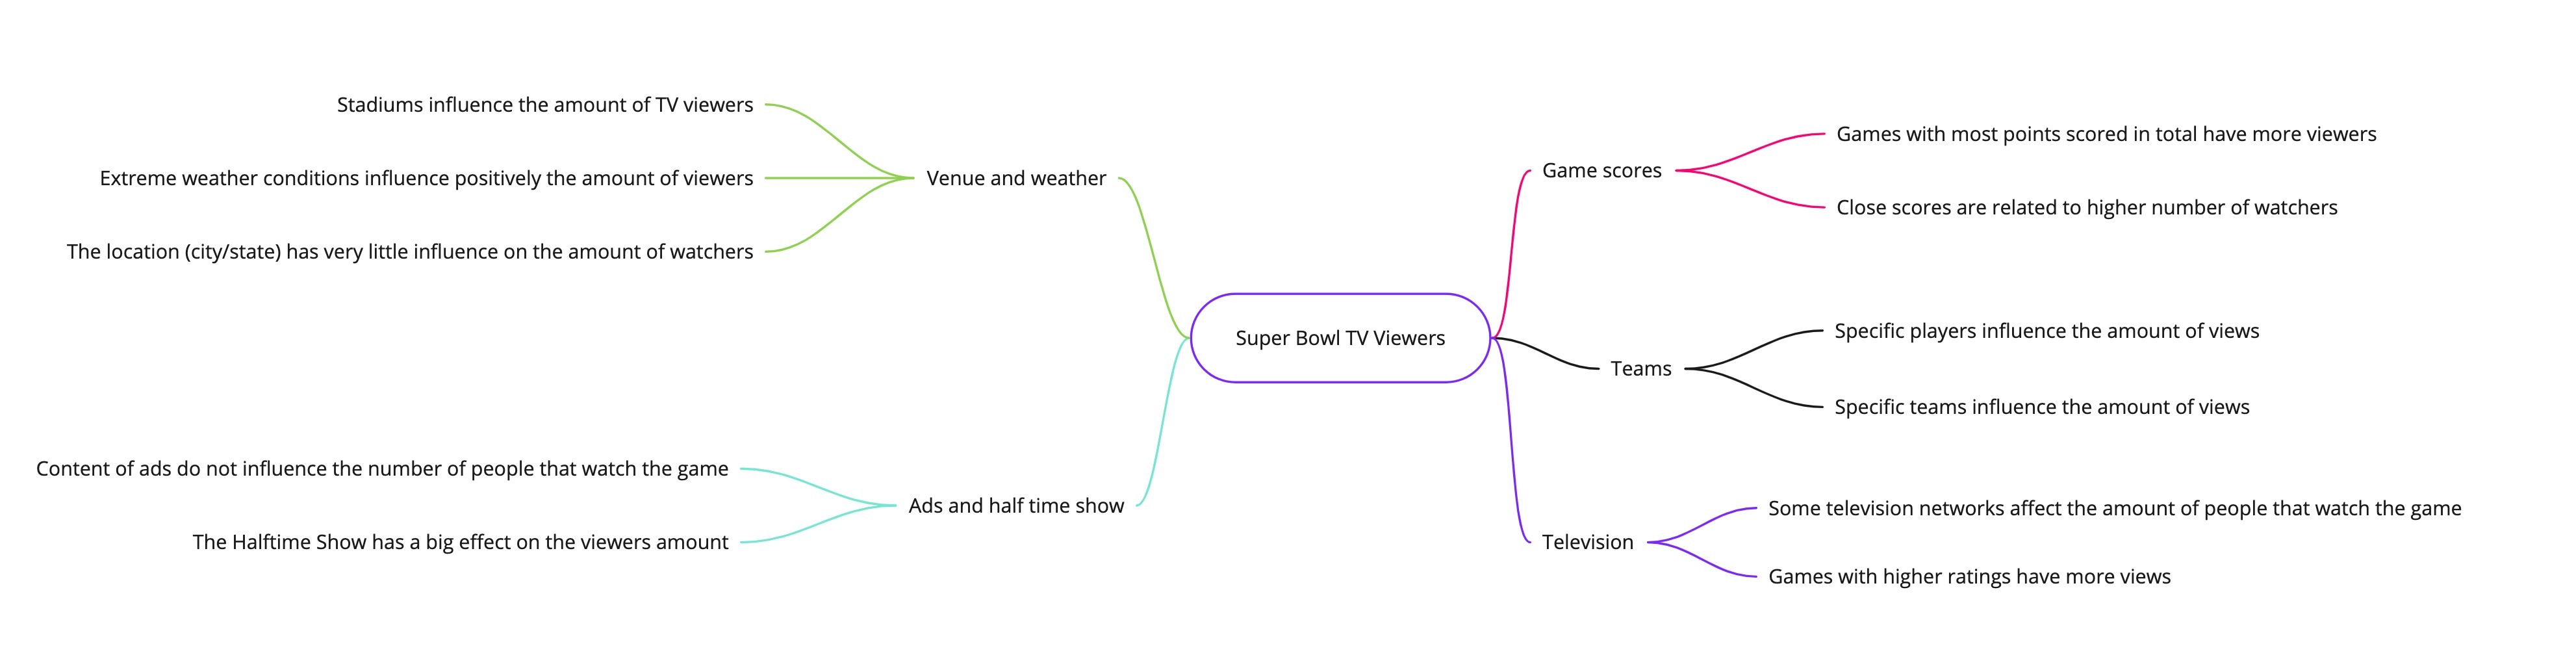

#### Some of the hypothesis will not be checked for the lack of proper data (in red). However, they could be used as suggestions for further development, as per the Readme file.

1. Close scores are related to higher number of watchers
2. Games with most points scored in total have more viewers
3. Specific players influence the amount of views
4. Specific teams influence the amount of views
5. Stadiums influence the amount of TV viewers
6. <span style="color:red">Extreme weather conditions influence positively the amount of viewers</span>
7. The location (city/state) has very little influence on the amount of watchers
8. <span style="color:red">The Halftime Show has a big effect on the viewers amount</span>
9. <span style="color:red">Content of ads do not influence the number of people that watch the game</span>
10. Some television networks affect the amount of people that watch the game
11. Games with higher ratings have more views

### 3.2. Data filtering

#### 3.2.1 Rows

In [327]:
# The first Super Bowl was in 1967 and, for some reason it was displayed on TV on two different networks. 

df3[df3['year'] == 1967]

year tv_network  nielsen_rating  tv_viewers       date sb_edition  \
55  1967        CBS            22.6       26.75 1967-01-15          I   
56  1967        NBC            18.5       24.43 1967-01-15          I   

    attendance             winner  qb__winner    coach_winner  ...  referee  \
55     61946.0  Green Bay Packers  Bart Starr  Vince Lombardi  ...      NaN   
56     61946.0  Green Bay Packers  Bart Starr  Vince Lombardi  ...      NaN   

   umpire head_linesman line_judge  field_judge back_judge side_judge  \
55    NaN           NaN        NaN          NaN        NaN        NaN   
56    NaN           NaN        NaN          NaN        NaN        NaN   

                                            geo_shape  \
55  {"coordinates": [[[-114.3549006824, 34.4646666...   
56  {"coordinates": [[[-114.3549006824, 34.4646666...   

                    geo_point_2d  total_points  
55  37.2551445335,-119.640543961            45  
56  37.2551445335,-119.640543961            45  

[2 rows x 30 columns]

In [328]:
# Since this information might not contribute to the model positevely, it will be removed from the dataset. As
# a suggestion for further development, it could be used on another project cycle, by adjusting the column values.

df3 = df3.drop([55,56], axis = 0)

#### 3.2.2. Columns

In [329]:
# Columns mentioned in 2.1 will be dropped here, along with the "Date","SB edition", "Coach Winner" and 
# "Coach Loser" columns.
df3 = df3.drop(['referee', 'umpire','head_linesman', 'line_judge', 'field_judge',
                'back_judge','side_judge','date','coach_loser', 'coach_winner', 'sb_edition', 'geo_shape', 'geo_point_2d'], axis = 1)

### 3.3. Dataframe check

In [330]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              55 non-null     int16  
 1   tv_network        55 non-null     object 
 2   nielsen_rating    55 non-null     float32
 3   tv_viewers        55 non-null     float32
 4   attendance        55 non-null     float32
 5   winner            55 non-null     object 
 6   qb__winner        55 non-null     object 
 7   winning_points    55 non-null     int16  
 8   loser             55 non-null     object 
 9   qb_loser          55 non-null     object 
 10  losing_points     55 non-null     int16  
 11  mvp               55 non-null     object 
 12  stadium           55 non-null     object 
 13  city              55 non-null     object 
 14  state             55 non-null     object 
 15  point_difference  55 non-null     int16  
 16  total_points      55 non-null     int16  
dtyp

## **4. EDA**

In [331]:
df4 = df3.copy()

### 4.1. Univariate analysis

#### 4.1.1. Target variable

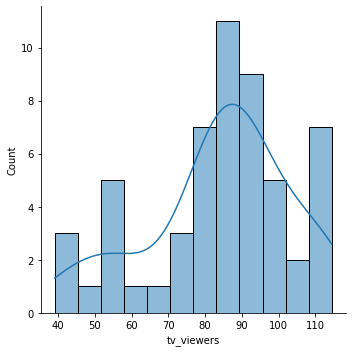

In [27]:
sns.displot(df4['tv_viewers'], bins = 12, kde = True);

#### 4.1.2. Numerical variables

- There is a reasonable correlation between year and tv viewers. As it is the target variable, this is not a bad thing.
- Attendance has very low values for correlation which a few other variables, which could indicate the need to remove it from the model.
- The rest of the data does not show strong signs of multicollinearity, which is a green light.

In [332]:
numerical_variables = df4.select_dtypes( include=['int16', 'float32'])
numerical_variables.columns

Index(['year', 'nielsen_rating', 'tv_viewers', 'attendance', 'winning_points',
       'losing_points', 'point_difference', 'total_points'],
      dtype='object')

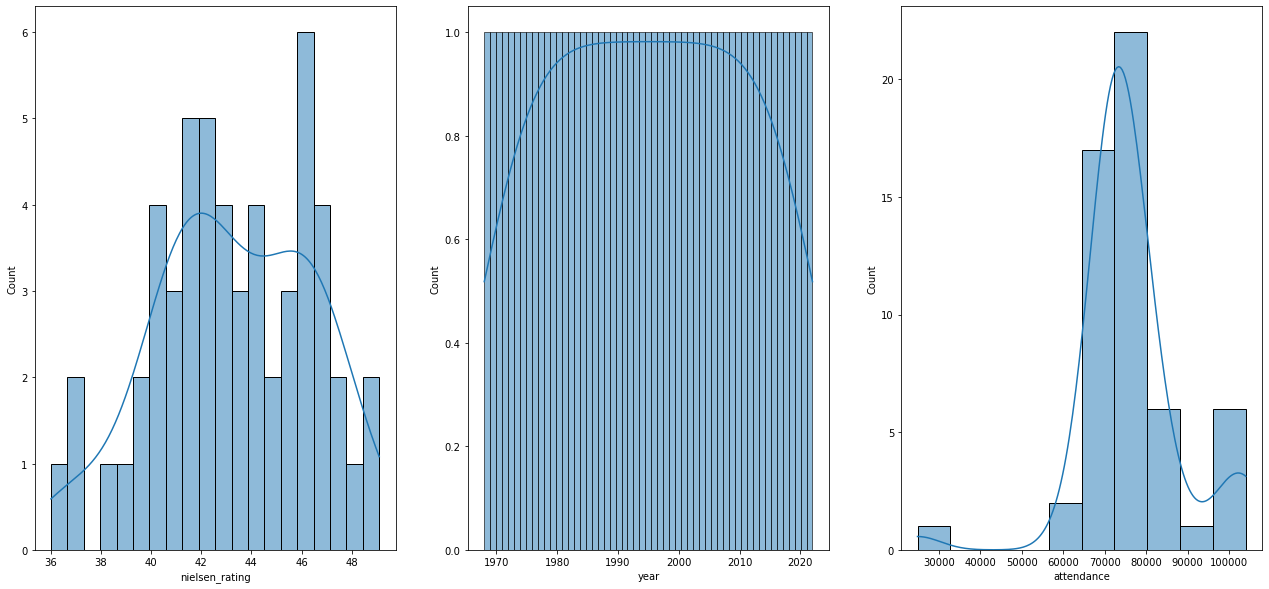

In [340]:
fig = plt.figure(figsize = (22,10))

plt.subplot(1,3,1)
sns.histplot(numerical_variables, x = 'nielsen_rating', kde = True, bins = 20)

plt.subplot(1,3,2)
sns.histplot(numerical_variables, x = 'year', kde = True, bins = 55)

plt.subplot(1,3,3)
sns.histplot(numerical_variables, x = 'attendance', kde = True, bins = 10);

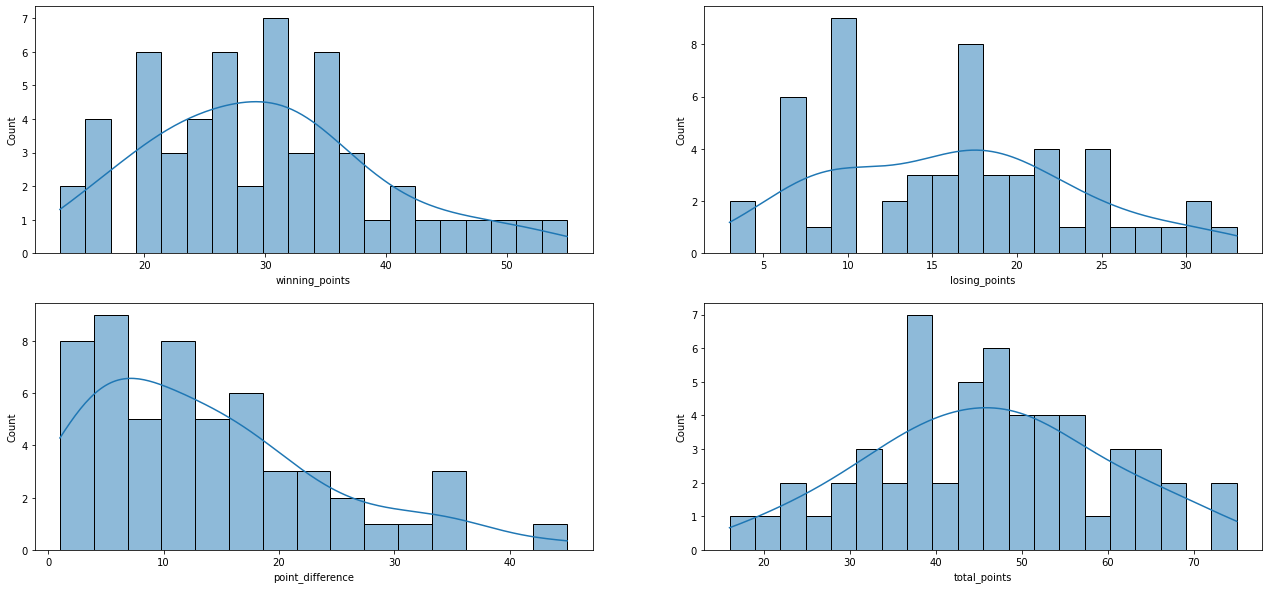

In [336]:
fig = plt.figure(figsize = (22,10))

plt.subplot(2,2,1)
sns.histplot(numerical_variables, x = 'winning_points', kde = True, bins = 20)

plt.subplot(2,2,2)
sns.histplot(numerical_variables, x = 'losing_points', kde = True, bins = 20)

plt.subplot(2,2,3)
sns.histplot(numerical_variables, x = 'point_difference', kde = True, bins = 15)

plt.subplot(2,2,4)
sns.histplot(numerical_variables, x = 'total_points', kde = True, bins = 20);

#### 4.1.3. Categorical variables

In this section, it is important to note that each variable is being evaluated individually in order to analyze whether they might feed good information to the model. As such, the columns "qb_winner", "qb_loser", "mvp" and stadium" should have very little to offer, since they are very varied. This subject and the lessons learned will be raised again further on the project, in the section "Variable selection".

In [31]:
categorical_variables = df4.select_dtypes( include=['object', 'bool'])
categorical_variables.columns

Index(['tv_network', 'winner', 'qb__winner', 'loser', 'qb_loser', 'mvp',
       'stadium', 'city', 'state'],
      dtype='object')

##### 4.1.3.1 Non-location plots

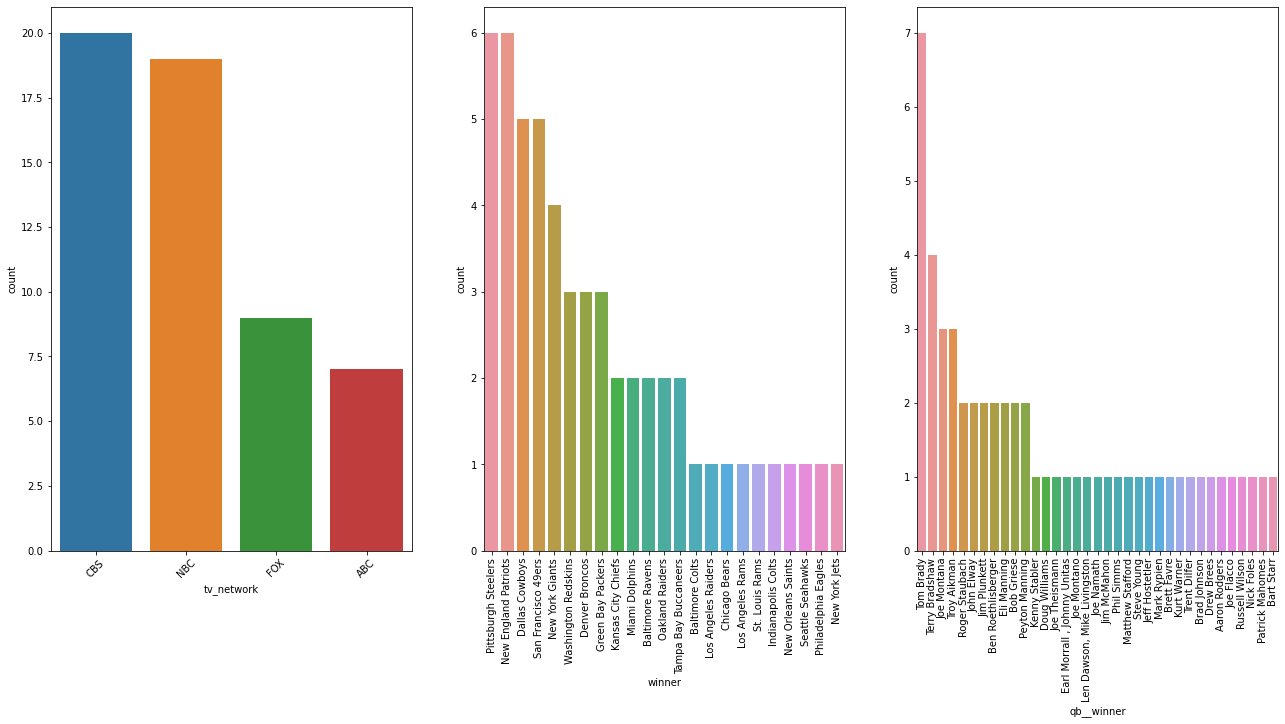

In [32]:
fig = plt.figure(figsize = (22,10))

plt.subplot(1,3,1)
sns.countplot(x = categorical_variables['tv_network'], order=categorical_variables['tv_network'].value_counts().index)
plt.xticks(rotation = 45)

plt.subplot(1,3,2)
sns.countplot(x = categorical_variables['winner'], order=categorical_variables['winner'].value_counts().index)
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.countplot(x = categorical_variables['qb__winner'], order=categorical_variables['qb__winner'].value_counts().index)
plt.xticks(rotation = 90);

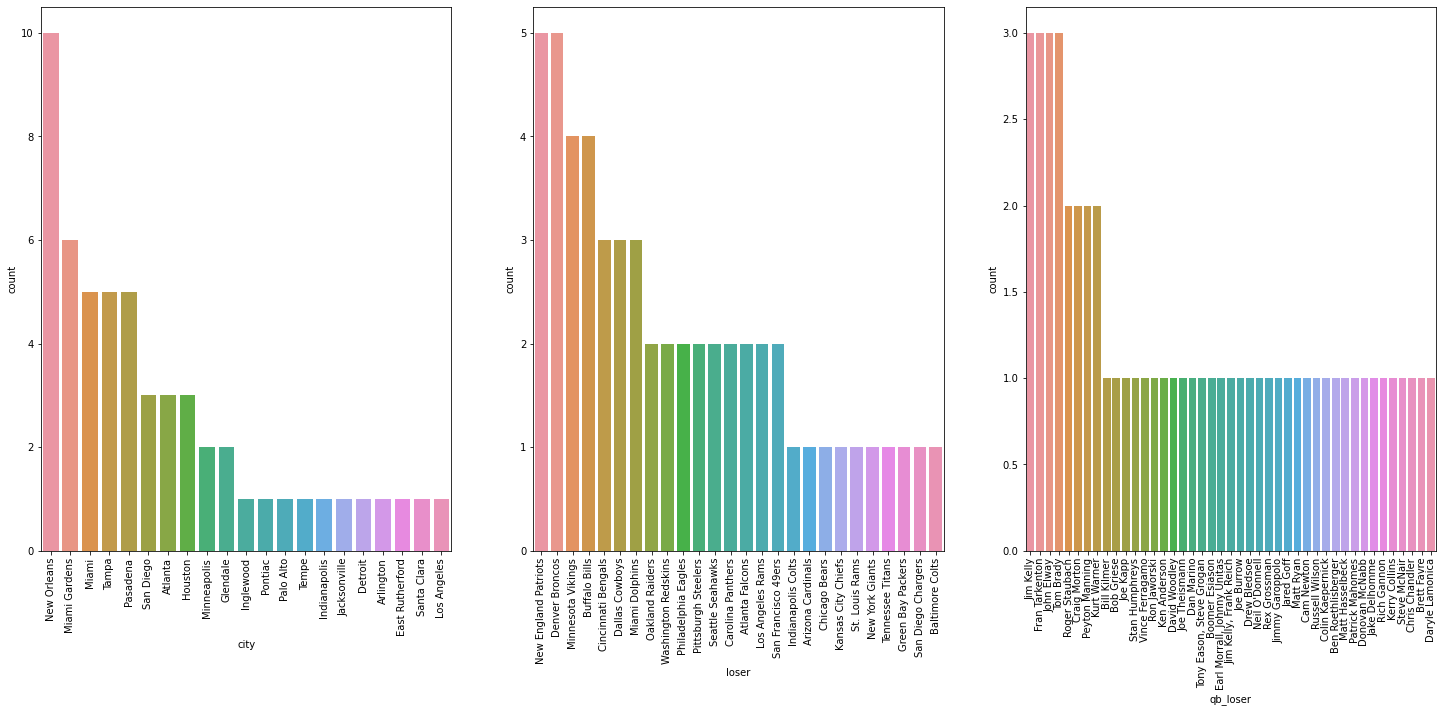

In [33]:
fig = plt.figure(figsize = (25,10))

plt.subplot(1,3,1)
sns.countplot(x = categorical_variables['city'], order=categorical_variables['city'].value_counts().index)
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.countplot(x = categorical_variables['loser'], order=categorical_variables['loser'].value_counts().index)
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.countplot(x = categorical_variables['qb_loser'], order=categorical_variables['qb_loser'].value_counts().index)
plt.xticks(rotation = 90);

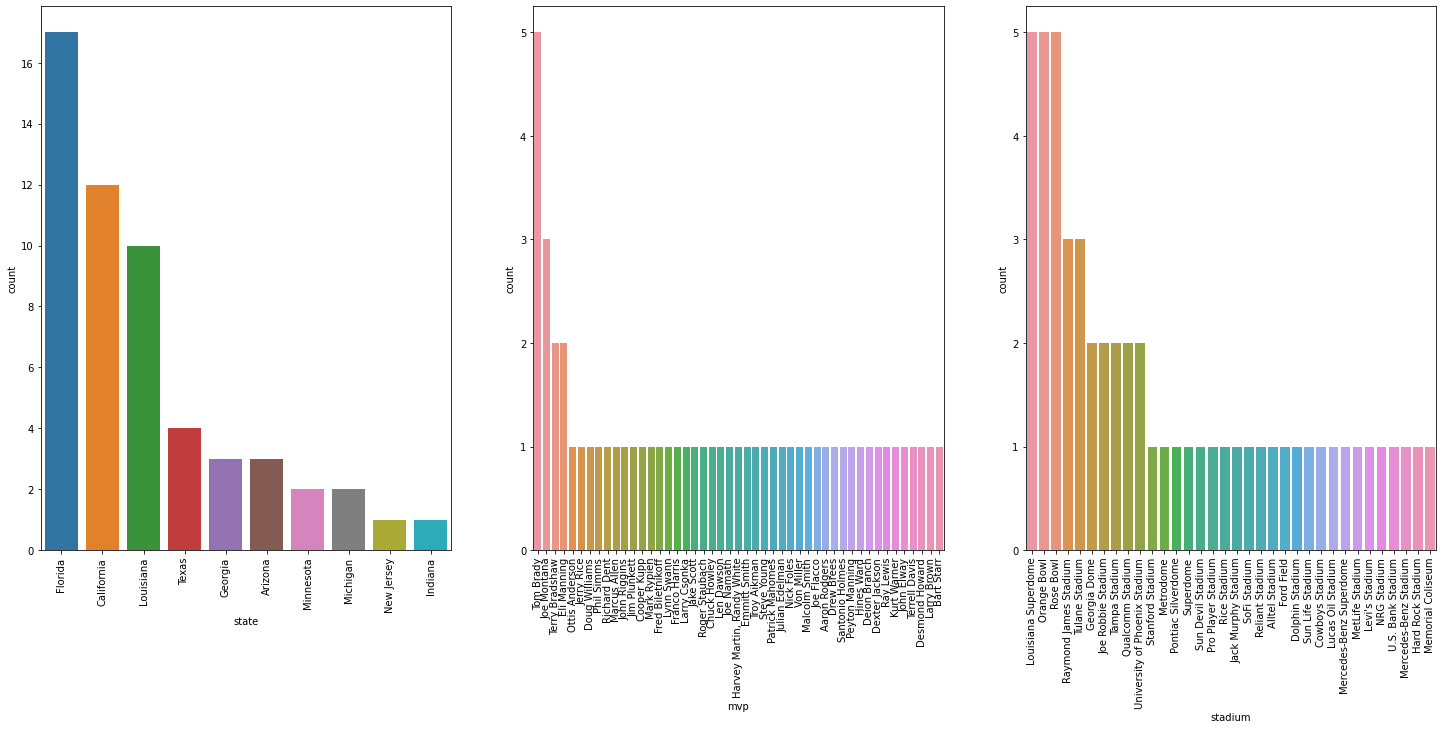

In [34]:
fig = plt.figure(figsize = (25,10))

plt.subplot(1,3,1)
sns.countplot(x = categorical_variables['state'], order=categorical_variables['state'].value_counts().index)
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.countplot(x = categorical_variables['mvp'], order=categorical_variables['mvp'].value_counts().index)
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.countplot(x = categorical_variables['stadium'], order=categorical_variables['stadium'].value_counts().index)
plt.xticks(rotation = 90);

##### 4.1.3.2 Location plot

In [35]:
location_data = df4[['state', 'city']]
location_plot1 = location_data[['state', 'city']].groupby('state').count().reset_index()
location_plot1.sort_values(ascending=False, by='city').head(3)

state  city
2     Florida    17
1  California    12
5   Louisiana    10

In [36]:
us_states = pd.read_html('https://www.bu.edu/brand/guidelines/editorial-style/us-state-abbreviations/')
us_states = us_states[0]
us_states.columns = ['state','abbreviation','two-letter-code']
us_states.drop([0], axis = 0, inplace = True)
us_states.head(3)

state     abbreviation two-letter-code
1   Alabama             Ala.              AL
2    Alaska  Alaska or Alas.              AK
3  Arkansas             Ark.              AR

In [37]:
location_plot1 = pd.merge(location_plot1, us_states, on="state", how='left')
location_plot1.head(3)

state  city abbreviation two-letter-code
0     Arizona     3        Ariz.              AZ
1  California    12       Calif.              CA
2     Florida    17         Fla.              FL

In [38]:
fig = px.choropleth(location_plot1,
                    locations='two-letter-code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color = 'city',
                    labels={
                     "city": "Super Bowls hosted"},
                    title="Super Bowls hosted by US state",
                    hover_name="state", 
                    hover_data={'two-letter-code':False})
fig.show()

### 4.2. Bivariate analysis

#### 4.2.1. Close scores are related to higher number of watchers

False. Lower point differences do not have higher ratings.

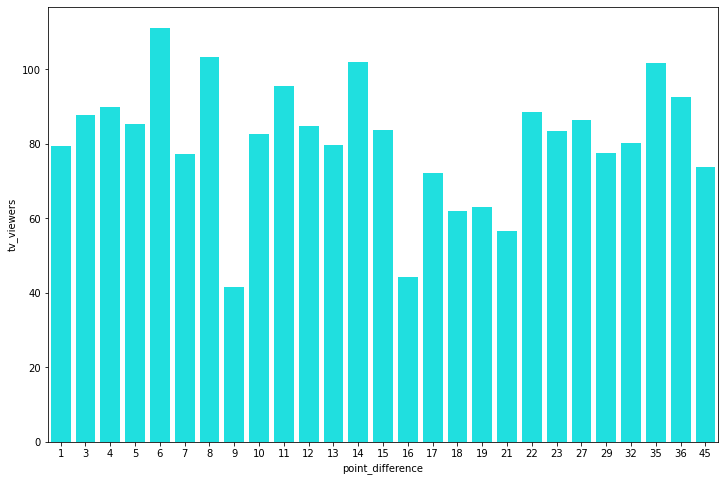

In [257]:
plot_data = df4[['tv_viewers', 'point_difference']].groupby('point_difference').mean().reset_index()

fig = plt.figure(figsize = (12,8))
sns.barplot(data=plot_data, x='point_difference', y='tv_viewers', color = 'cyan');

#### 4.2.2. Games with most points scored in total have more viewers

True. Games with very low point totals have fewers views.

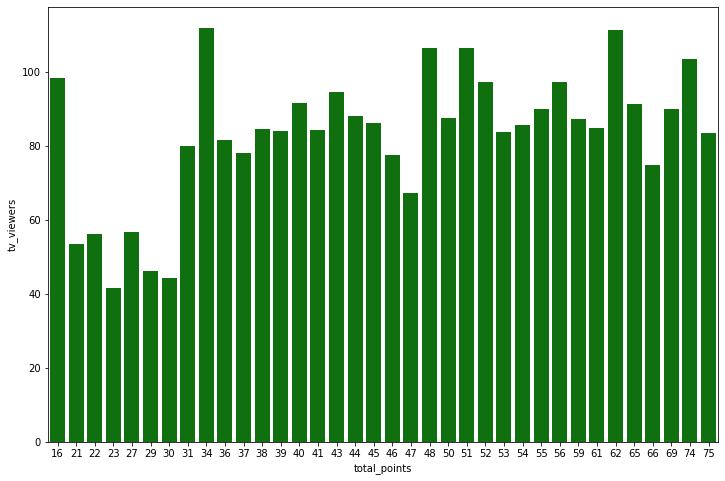

In [342]:
plot_data = df4[['tv_viewers', 'total_points']]
plot_data = plot_data[['tv_viewers', 'total_points']].groupby('total_points').mean().reset_index()

fig = plt.figure(figsize = (12,8))
sns.barplot(data=plot_data, x='total_points', y='tv_viewers', color = 'green');

#### 4.2.1. 3. Specific players influence the amount of views

Uncertain. **There is a definite trend** here, however, is might also be related to the growth of popularity over the years.

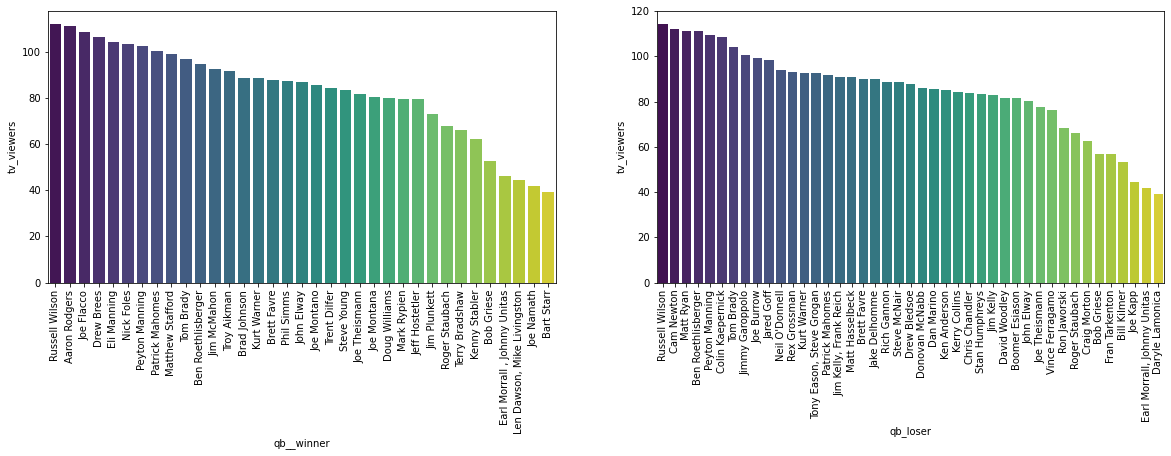

In [82]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plot_data = df4[['tv_viewers', 'qb__winner']].groupby("qb__winner").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'qb__winner', y='tv_viewers', order = plot_data['qb__winner'].tolist(),palette = 'viridis')
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
plot_data = df4[['tv_viewers', 'qb_loser']].groupby("qb_loser").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'qb_loser', y='tv_viewers', order = plot_data['qb_loser'].tolist(), palette = 'viridis')
plt.xticks(rotation = 90);

#### 4.2.4. Specific teams influence the amount of views

Uncertain. Just like in 4.2.3., **there is a trend**, however, is might also be related to the growth of popularity over the years.

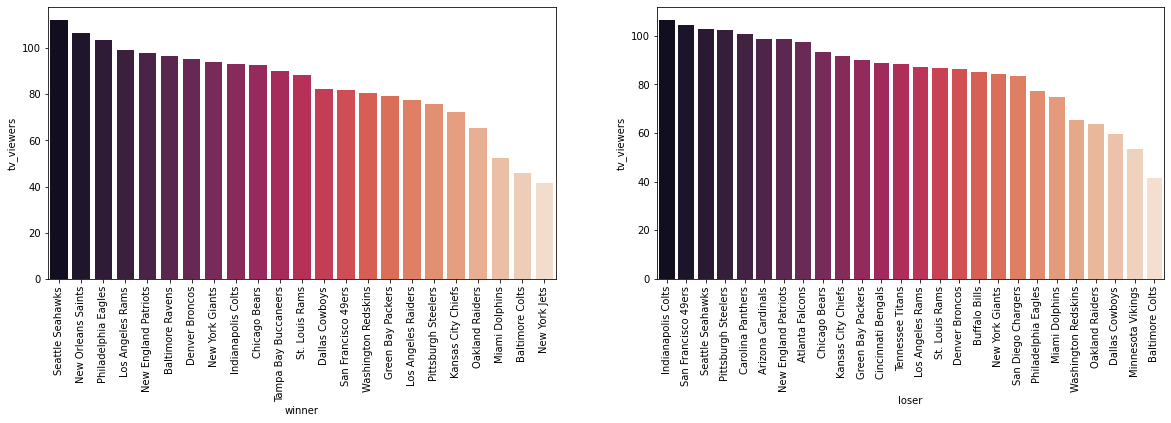

In [84]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plot_data = df4[['tv_viewers', 'winner']].groupby("winner").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'winner', y='tv_viewers', order = plot_data['winner'].tolist(), palette = 'rocket')
plt.xticks(rotation = 90);

plt.subplot(1,2,2)
plot_data = df4[['tv_viewers', 'loser']].groupby("loser").mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')
sns.barplot(data=plot_data, x = 'loser', y='tv_viewers', order = plot_data['loser'].tolist(), palette = 'rocket')
plt.xticks(rotation = 90);

#### 4.2.5. Stadiums influence the amount of TV viewers

"Medium true". Stadiums seem to influence a little more than players, just like teams. It seems there are three distinct tiers: 

    1.Less than 60M;
    2.Less than 95M;
    3.More than 95M.

In [253]:
fig = plt.figure(figsize = (15,20))
plot_data = df4[['tv_viewers', 'stadium']].groupby('stadium').mean().reset_index().sort_values(by = 'tv_viewers')
fig = px.bar(plot_data, x = 'tv_viewers', y = 'stadium')
fig.show()

<Figure size 1080x1440 with 0 Axes>

#### 4.2.7. The location (city/state) has very little influence on the amount of watchers

"Medium true", as well. Same interpretation as 4.2.5. (stadiums).

In [256]:
plot_data = df4[['city', 'tv_viewers']].groupby('city').mean().reset_index().sort_values(by='tv_viewers')
fig = px.bar(plot_data, x = 'city', y = 'tv_viewers')
fig.show()

#### 4.2.10. Some television networks affect the amount of people that watch the game

True. 'Fox' seems to have a lot more watchers than all the other networks.

In [247]:
plot_data = df4[['tv_viewers', 'tv_network']].groupby('tv_network').mean().reset_index().sort_values(ascending = False, by = 'tv_viewers')

fig = plt.figure(figsize = (12,8))
fig = px.bar(plot_data, x='tv_network', y='tv_viewers', 
             labels = {'tv_viewers' : 'TV viewers', 'tv_network' : 'TV network'},
             hover_name = 'tv_network',
             hover_data = {'tv_network': False})
fig.show()

<Figure size 864x576 with 0 Axes>

#### 4.2.11. Games with higher ratings have more views

True. As expected, the more viewership share a Super Bowl edition has, the more viewers. 

In [259]:
# Create a new column with 'Rtg' values as categories. This would normally be done in 2.2., but
# it would change the category boundaries.

df4['nielsen_rating_categories'] = pd.cut(df4['nielsen_rating'], 5).astype(str)

In [263]:
plot_data = df4[['nielsen_rating_categories', 'tv_viewers']].groupby('nielsen_rating_categories').mean().reset_index().sort_values(ascending = False, by='tv_viewers')
fig = plt.figure(figsize = (12,8))
#sns.barplot(data = plot_data, x = 'nielsen_rating_categories', y='tv_viewers')
fig = px.bar(plot_data, x = 'nielsen_rating_categories', y='tv_viewers')
fig.show()

<Figure size 864x576 with 0 Axes>

### 4.3. Multivariate analysis

#### 4.3.1. Numerical variables

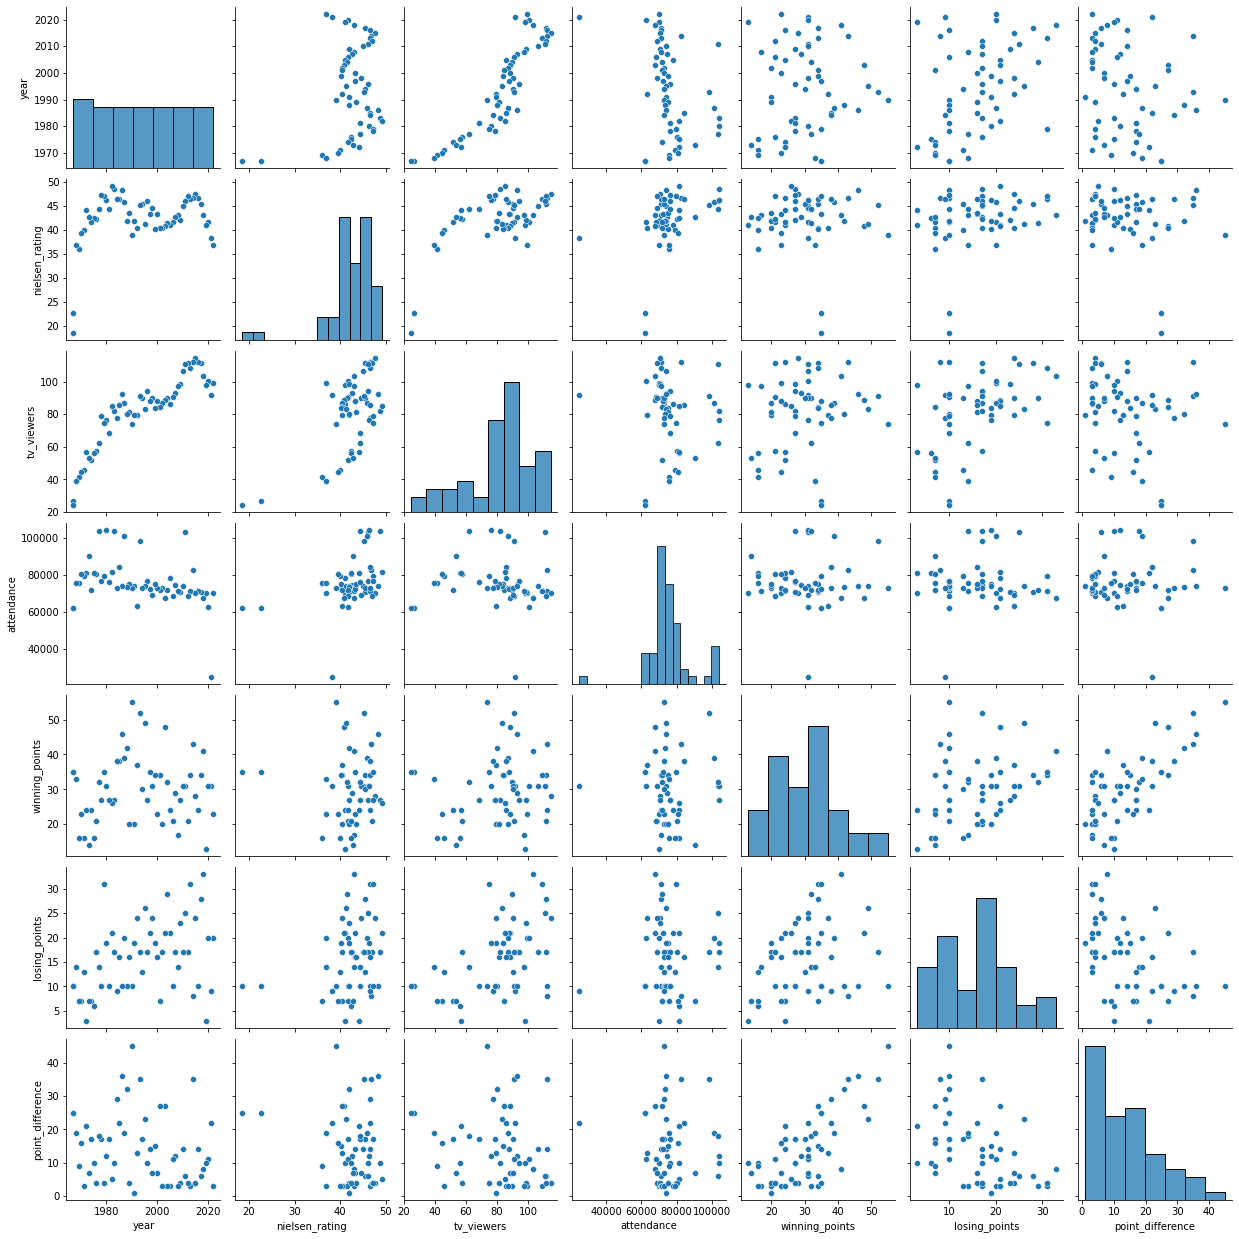

In [29]:
sns.pairplot(numerical_variables);

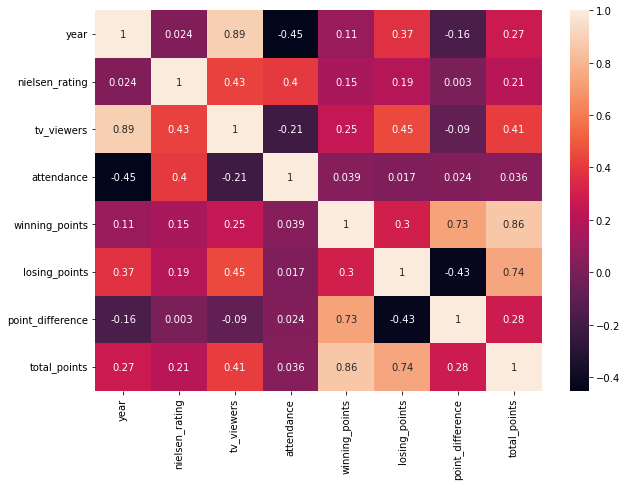

In [343]:
fig = plt.figure(figsize = (10,7))
fig = sns.heatmap(numerical_variables.corr(), annot = True)

#### 4.3.2. Categorical variables

As expected and shown in the figure below, there is a perfect correlation between a few of those categorical variables:

    -State, city and stadium.

Some other very high correlations were found:

    -MVP, QB winner and winner;
    -QB loser and loser.

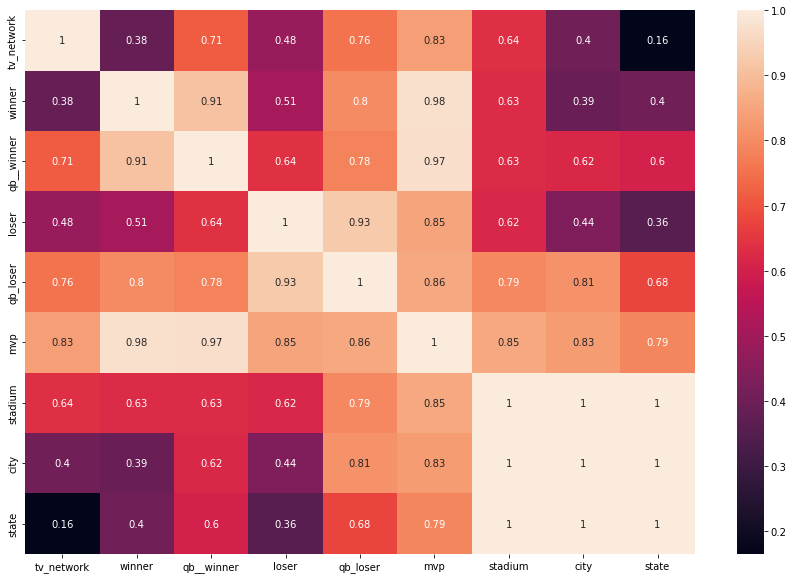

In [389]:
categorical_variables_correlation = build_cramersv_dataframe(categorical_variables)

fig = plt.figure(figsize = (15,10))
sns.heatmap(categorical_variables_correlation, annot = True);

## 5. DATA PREPARATION

In [440]:
df5 = df4.copy()

### 5.1. Normalization/scaling

In [441]:
sc = StandardScaler()

pd.set_option('display.float_format', lambda x: '%.3f' % x)
df5['nielsen_rating'] = sc.fit_transform(df5[['nielsen_rating']].values)
df5['attendance'] = sc.fit_transform(df5[['nielsen_rating']].values)
df5['winning_points'] = sc.fit_transform(df5[['winning_points']].values)
df5['losing_points'] = sc.fit_transform(df5[['losing_points']].values)
df5['point_difference'] = sc.fit_transform(df5[['point_difference']].values)
df5['total_points'] = sc.fit_transform(df5[['total_points']].values)

In [442]:
df5.describe()

year  nielsen_rating  tv_viewers  attendance  winning_points  \
count   55.000          55.000      55.000      55.000          55.000   
mean  1995.000          -0.000      83.925      -0.000          -0.000   
std     16.021           1.009      19.271       1.009           1.009   
min   1968.000          -2.336      39.120      -2.336          -1.759   
25%   1981.500          -0.665      76.930      -0.665          -0.719   
50%   1995.000          -0.054      86.800      -0.054           0.009   
75%   2008.500           0.877      95.765       0.877           0.478   
max   2022.000           1.874     114.440       1.874           2.611   

       losing_points  point_difference  total_points  
count         55.000            55.000        55.000  
mean           0.000             0.000        -0.000  
std            1.009             1.009         1.009  
min           -1.813            -1.243        -2.199  
25%           -0.855            -0.900        -0.668  
50%            0.102            -0.261        -0.012  
75%            0.649             0.476         0.681  
max            2.290             3.080         2.103

### 5.2. Encoding

In [443]:
df5 = pd.get_dummies(df5,columns = ['tv_network', 'winner','loser','city'], drop_first=True)

In [445]:
df5.shape

(55, 83)

## 6. FEATURE SELECTION

In [526]:
df6 = df5.copy()

In [527]:
y = df6['tv_viewers'].values.ravel()
X = df6.drop(columns = ['tv_viewers','qb__winner', 'qb_loser', 'mvp', 'state', 'stadium'], axis = 1).values

In [528]:
#https://github.com/scikit-learn-contrib/boruta_py
    
rf = RandomForestRegressor(n_jobs=-1)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	77
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	5
Rejected: 	72
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	72
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	73
I

BorutaPy(estimator=RandomForestRegressor(n_estimators=28, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F82B013A440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F82B013A440, verbose=2)

In [529]:
boruta_selected_columns = df6.drop(columns = ['tv_viewers', 'qb__winner', 'qb_loser', 'mvp', 'state', 'stadium'], axis = 1).iloc[:, feat_selector.support_.tolist()]
boruta_selected_columns.columns

Index(['year', 'nielsen_rating', 'attendance'], dtype='object')

In [530]:
other_selected_columns = ['point_difference','tv_network_CBS','tv_network_FOX', 'tv_network_NBC']
final_columns = boruta_selected_columns.columns.tolist() + other_selected_columns
final_columns.append('tv_viewers')

In [535]:
df6 = df6.loc[:,final_columns]
df6.shape

(55, 8)

## 7. MODELING